In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from math import pi
import plancklens
from plancklens import utils, n0s
from plancklens import nhl
from plancklens.n1 import n1
from plancklens import qest, qecl, qresp
import matplotlib as mpl

from orphics import maps, cosmology
mpl.rcParams['font.size']=12

In [2]:
exps_config = {
    'CMB_S3': {
        'nlev_t': 7,
        'nlev_p':7*2**0.5,
        'beam_arcmin': 1.4,
        'result_nums': [0, 20, 40, 60, 80]
    },
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 1.4,
        'result_nums': [90, 110, 130, 150, 170]
    }
}

In [69]:
A_cb = 1e-06
experiment = 'CMB_S3'

lmax = 3000
ellmin = 30
ellmax = 3000
Lmax = 3000

ls = np.arange(lmax+1)
ells = np.arange(ellmax+1)

In [70]:
theory = cosmology.default_theory()
cltt, clee, clbb = theory.lCl('TT', ls), theory.lCl('EE', ls), theory.lCl('BB', ls)
clte = theory.lCl('TE', ls)

In [71]:
main_path = '/home/hongbo/projects/lens_rot_bias/'
cls_path = '/home/hongbo/projects/lens_rot_bias/inputPs'
claa = np.loadtxt(cls_path + '/claa_A%s.txt' %A_cb)[:,1]

In [72]:
clpp = np.loadtxt(cls_path + '/cosmo2017_10K_acc3_lenspotentialCls.dat', \
                  usecols=(5), unpack=True)
fac = (ls*(ls+1))**2/(2*pi)
fac[0] = 1
clpp = np.concatenate(([1,1], clpp))[ls]/fac
clpp[0], clpp[1] = 0, 0

In [73]:
nltt = (exps_config[experiment]['nlev_t']*\
        pi/180/60)**2/maps.gauss_beam(ls, exps_config[experiment]['beam_arcmin'])**2
nlee = (exps_config[experiment]['nlev_p']*\
        pi/180/60)**2/maps.gauss_beam(ls, exps_config[experiment]['beam_arcmin'])**2
nlbb = nlee

ocltt = cltt + nltt
oclee = clee + nlee
oclbb = clbb + nlbb
oclee[0], oclee[1], oclbb[0], oclbb[1] = 1, 1, 1, 1

In [74]:
ftl = 1/ocltt[:lmax+1]
fel = 1/oclee[:lmax+1]
fbl = 1/oclbb[:lmax+1]

# ftl[:ellmin] *= 0.
# fel[:ellmin] *= 0.
# fbl[:ellmin] *= 0.

ftl[:2] *= 0.
fel[:2] *= 0.
fbl[:2] *= 0.

In [75]:
n1aa_integral = []

for result_num in exps_config[experiment]['result_nums']:
    n1aa_integral.append(np.loadtxt(main_path+'/output/N1aa/N1aa_%s_%s_%s_30_3000.dat' \
                                    %(result_num, A_cb, experiment)))

n1aa_integral = np.array(n1aa_integral)
n1aa_sim = np.mean(n1aa_integral, axis=0)

In [76]:
#---- N1 lensing bias library:
n1_dd = n1.library_n1(main_path+'/test_N1aa/N1aa_db/',cltt,clte,clee)

In [77]:
n1aa = n1_dd.get_n1('peb', 'r', claa[:4001], ftl, fel, fbl, 3000)

n1: doing L 1 kA peb kB peb kind r
n1: doing L 2 kA peb kB peb kind r
n1: doing L 3 kA peb kB peb kind r
n1: doing L 4 kA peb kB peb kind r
n1: doing L 5 kA peb kB peb kind r
n1: doing L 6 kA peb kB peb kind r
n1: doing L 7 kA peb kB peb kind r
n1: doing L 8 kA peb kB peb kind r
n1: doing L 9 kA peb kB peb kind r
n1: doing L 10 kA peb kB peb kind r
n1: doing L 21 kA peb kB peb kind r
n1: doing L 41 kA peb kB peb kind r
n1: doing L 61 kA peb kB peb kind r
n1: doing L 81 kA peb kB peb kind r
n1: doing L 101 kA peb kB peb kind r
n1: doing L 121 kA peb kB peb kind r
n1: doing L 141 kA peb kB peb kind r
n1: doing L 161 kA peb kB peb kind r
n1: doing L 181 kA peb kB peb kind r
n1: doing L 201 kA peb kB peb kind r
n1: doing L 221 kA peb kB peb kind r
n1: doing L 241 kA peb kB peb kind r
n1: doing L 261 kA peb kB peb kind r
n1: doing L 281 kA peb kB peb kind r
n1: doing L 301 kA peb kB peb kind r
n1: doing L 321 kA peb kB peb kind r
n1: doing L 341 kA peb kB peb kind r
n1: doing L 361 kA peb k

In [78]:
cls_weights = {'tt':cltt,'ee':clee, 'bb':clbb,'te':clte}
cls_ivfs = {'tt':ftl, 'ee': fel, 'bb':fbl}
R = qresp.get_response('p_eb', 3000, 'p', cls_weights, cls_weights, cls_ivfs)[0][:3001]

In [79]:
# n1aa_plancklens = np.concatenate(([0,0],2.5*(1/R[2:]**2)*n1aa[2:]))
# np.savetxt('../output/N1aa_plancklens/N1aa_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat', n1aa_plancklens)

In [84]:
n1aa_plancklens = np.loadtxt('../output/N1aa_plancklens/N1aa_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat')

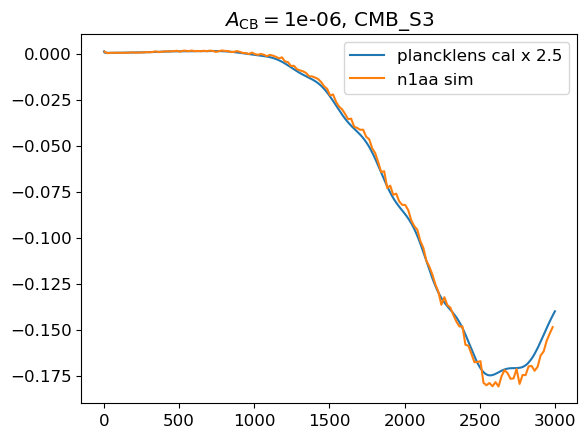

In [85]:
Ls = np.arange(5, ellmax+1, 20)
clpp[2:]
plt.plot(ls[2:], n1aa_plancklens[2:]/clpp[2:], label='plancklens cal x 2.5')
plt.plot(Ls, n1aa_sim[Ls]/clpp[Ls], label='n1aa sim')
plt.title(r"$A_{\rm CB}=$%s, %s"%(A_cb, experiment))
plt.legend()